In [1]:
# %load_ext pycodestyle_magic
# %flake8_on

In [2]:
import os
import sys
import random

import albumentations as A
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xml.etree.ElementTree as ET

from tensorflow.keras import models, layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Softmax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import CSVLogger

# Check versions of libraries
print(f"Python: {sys.version}")
print(f"numpy: {np.__version__}")
print(f"matplotlib: {mpl.__version__}")
print(f"OpenCV: {cv2.__version__}")
print(f"Tensorflow: {tf.__version__}")

Python: 3.8.10 (default, May 19 2021, 18:05:58) 
[GCC 7.3.0]
numpy: 1.20.2
matplotlib: 3.2.2
OpenCV: 4.5.2
Tensorflow: 2.2.0


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4608)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [4]:
CURRENT_DIR = os.getcwd()
TRAINING_SET_DIR = os.path.join(CURRENT_DIR, "images", "training_set")
VALIDATION_SET_DIR = os.path.join(CURRENT_DIR, "images", "validation_set")

IMAGE_WIDTH = 300
IMAGE_HEIGHT = 300

BATCH_SIZE = 32
EPOCHS = 30

In [5]:
train_image_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=(0.8, 1.2),
        horizontal_flip=True)

validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_generator = train_image_generator.flow_from_directory(
        TRAINING_SET_DIR,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=BATCH_SIZE,
        shuffle=True,
        class_mode='categorical')

validation_data_generator = validation_image_generator.flow_from_directory(
        VALIDATION_SET_DIR,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical')


Found 65228 images belonging to 130 classes.
Found 5200 images belonging to 130 classes.


In [6]:
NUMBER_OF_TRAINING_IMAGES = train_data_generator.samples
NUMBER_OF_VALIDATION_IMAGES = validation_data_generator.samples

In [7]:
# displays a (num x num) array of randomly selected augmented images
def augmentedImageView(datagen, num):
    fig, ax = plt.subplots(num, num, figsize=(num*4,num*4))
    for i in range(num):
        for j in range(num):
            img, label = datagen.next()
            ax[i, j].imshow(img[0])

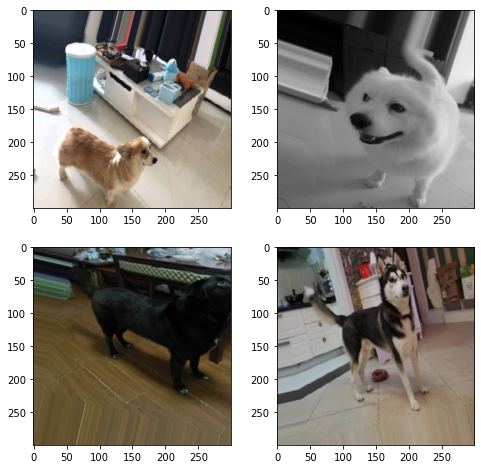

In [8]:
augmentedImageView(train_data_generator, 2)

In [9]:
base_model = VGG16(include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3),
    pooling="avg")

# Freeze the weights of the VGG-16 layers
for layer in base_model.layers[:14]:
    layer.trainable = False

base_model.summary()
    
vgg_model = models.Sequential()
vgg_model.add(base_model)
vgg_model.add(Dropout(0.2))
vgg_model.add(Dense(512, activation="relu"))
vgg_model.add(Dense(256, activation="relu"))
vgg_model.add(Dense(130, activation="softmax"))

vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [10]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
vgg_model.compile(loss="categorical_crossentropy",
             optimizer=opt,
             metrics=["accuracy"])

model_csvlogger = CSVLogger("csv_logs/model_history.log", separator=",", append=False)

In [11]:
history = vgg_model.fit(train_data_generator,
                  validation_data = validation_data_generator,
                  epochs = EPOCHS,
                  verbose = 1,
                  steps_per_epoch = NUMBER_OF_TRAINING_IMAGES//BATCH_SIZE,
                  validation_steps = NUMBER_OF_VALIDATION_IMAGES//BATCH_SIZE,
                  callbacks = [model_csvlogger])

Epoch 1/30
2038/2038 [==============================] - 993s 487ms/step - loss: 2.9297 - accuracy: 0.2843 - val_loss: 3.4957 - val_accuracy: 0.1418
Epoch 2/30
2038/2038 [==============================] - 984s 483ms/step - loss: 2.0587 - accuracy: 0.4562 - val_loss: 2.7628 - val_accuracy: 0.2637
Epoch 3/30
2038/2038 [==============================] - 986s 484ms/step - loss: 1.7876 - accuracy: 0.5087 - val_loss: 2.3757 - val_accuracy: 0.3443
Epoch 4/30
2038/2038 [==============================] - 987s 484ms/step - loss: 1.6255 - accuracy: 0.5455 - val_loss: 2.4542 - val_accuracy: 0.3380
Epoch 5/30
2038/2038 [==============================] - 986s 484ms/step - loss: 1.5266 - accuracy: 0.5692 - val_loss: 2.1849 - val_accuracy: 0.3970
Epoch 6/30
2038/2038 [==============================] - 986s 484ms/step - loss: 1.4551 - accuracy: 0.5819 - val_loss: 2.1689 - val_accuracy: 0.4138
Epoch 7/30
2038/2038 [==============================] - 987s 484ms/step - loss: 1.4152 - accuracy: 0.5912 - val_

In [12]:
vgg_model.save("saved_model/vgg_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/vgg_model/assets


In [15]:
vgg_model.save("saved_model/vgg_model.h5")

In [13]:
def plot_model(history):
    fig, (ax1, ax2)=plt.subplots(1,2, figsize=(14,6), sharex="all")
    ax1.plot(history.history['accuracy'], label="Accuracy", marker="o")
    ax1.plot(history.history['val_accuracy'], label="Validation Accuracy", marker="o")
    
    ax1.set_xlabel("Number of epochs")
    ax1.set_ylabel("Accuracy")
    ax1.legend()
    
    ax2.plot(history.history['loss'], label="Loss", marker="o")
    ax2.plot(history.history['val_loss'], label="Validation Loss", marker="o")
    
    ax2.set_xlabel("Number of epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    
    plt.savefig("figures/history_plot.png")
    plt.show()

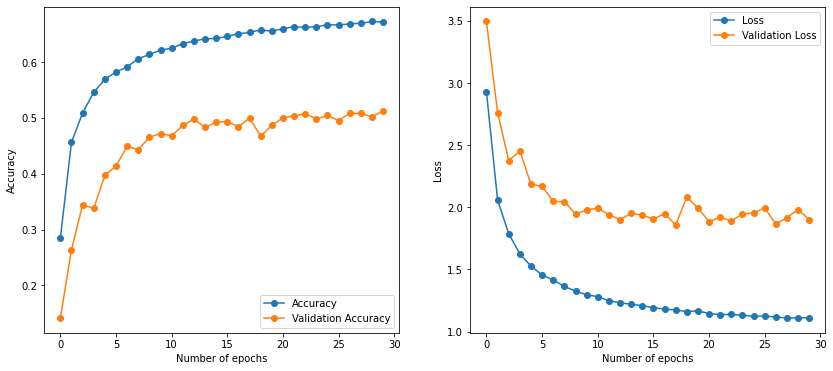

In [14]:
plot_model(history)